# **ColPali**
## **Improving multimodal retrieval** : *Increasing training difficulty*

This fine-tuning project aims to enhance the ColPali multimodal model by addressing some of the inherent limitations in its current training methodology. ColPali relies on a Maximum Similarity (MaxSim) calculation, performed between each image patch and each query token for every page, sequentially and independently.

Training is currently performed using in-batch contrastive learning on query-document pairs (q, d), where d is a positive document, and negatives are sampled from other documents in the batch. The model focuses on the hardest negative within this batch.

While this method does help the model learn to distinguish relevant from misleading documents, its effectiveness is limited by the quality of negatives in the batch. If the selected negative is relatively "easy" (i.e., obviously irrelevant), the model may fail to differentiate between two pages that both contain the query tokens, but only one of which actually answers the question.

To improve the model's ability to retrieve the correct page, we propose a new training strategy for ColPali : we fine-tune it using a multi-negative pairwise contrastive loss, inspired by triplet loss. Specifically, for each query, we select the positive document and the three semantically closest negatives (the hardest negatives across the entire dataset), rather than relying on negatives from within a mini-batch.

The loss is computed using a softplus function on the difference between each negative score and the positive score. This encourages the model to focus on subtle semantic distinctions between very similar pages, and results in a more difficult and informative training signal.

Unlike the traditional triplet loss, which uses a fixed margin, our approach employs a smoother formulation and handles multiple negatives simultaneously. This allows the model to learn finer-grained decision boundaries.

Training was conducted on an A100 GPU.

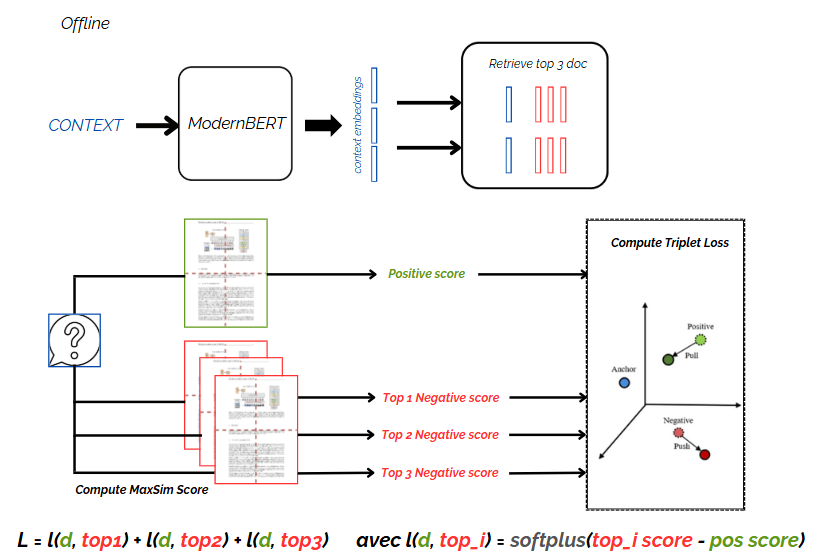

In [1]:
from IPython.display import Image, display
display(Image(filename='sft_colpali.png', width=700))

**Pre-Generation of Top-3 Hardest Negatives**

Using **vLLM**, we generate a textual context for each image page in the ColPali training dataset. These contexts are then embedded using **ModernBERT**, producing dense vector representations.

Using **FAISS GPU**, we pre-generated a list of IDs for the top-3 hardest negatives for each page by retrieving the three most semantically similar pages across the dataset (excluding the ground truth). These examples are used to provide stronger negative supervision during training.

**LoRA config**

We use **LoRA 4-bit** to fine-tune the model efficiently with low memory usage.

### **New classes needed for fine tuning**

**Custom collator**

We create a custom collator named *Top3SemanticCollator*.  
This collator prepares input batches such that each training example includes:

- A **positive image** (referred to as `'image'`)
- A list of **three hard negative images** (from `closest_indices`)

To ensure true negatives:
- Some images may answer different queries but come from the same file. To prevent data leakage, we filter out any negatives that have the same `"image_filename"` as the positive.

Each image (positive and negatives) is passed through `process_images()` to generate `input_ids`, `attention_mask`, and `pixel_values`.  
The associated query is passed through `process_queries()`.

**Custom loss**

We define our loss function as a triplet loss adapted to multimodal retrieval, imposing the similarity between the query and positive doc to be superior to the similarity between the query and each negative docs.

First, we compute the MaxSim scores for each pairs ((query - positive doc) and (query - each negative doc)) :

        pos_scores = torch.einsum("bnd,bsd->bns", query_embeddings, doc_embeddings) \
                        .max(dim=2)[0] \
                        .sum(dim=1)
        neg1_scores = torch.einsum("bnd,bsd->bns", query_embeddings, neg1_embeddings) \
                         .max(dim=2)[0] \
                         .sum(dim=1)
        neg2_scores = torch.einsum("bnd,bsd->bns", query_embeddings, neg2_embeddings) \
                         .max(dim=2)[0] \
                         .sum(dim=1)
        neg3_scores = torch.einsum("bnd,bsd->bns", query_embeddings, neg3_embeddings) \
                         .max(dim=2)[0] \
                         .sum(dim=1)

For each negative, we then compute :

        loss1 = F.softplus(neg1_scores - pos_scores)
        loss2 = F.softplus(neg2_scores - pos_scores)
        loss3 = F.softplus(neg3_scores - pos_scores)

Final loss is the mean of the sum of each negative loss :

        loss_main = (loss1 + loss2 + loss3) / 3.0
        loss_main = loss_main.mean()

It ensures that the query is efficiently closed to its positive doc and eloigné de chacun de ses proches doc candidats potentiels.

**Custom trainer**

Inheriting from Huggingface Trainer, our Trainer extracts the embeddings of : query, positive doc, top1...top3 neg doc :

        query_outputs = model(
            input_ids=inputs["query_input_ids"],
            attention_mask=inputs["query_attention_mask"]
        )
        doc_outputs = model(
            input_ids=inputs["doc_input_ids"],
            attention_mask=inputs["doc_attention_mask"],
            pixel_values=inputs["doc_pixel_values"]
        )
        top1_outputs = model(
            input_ids=inputs["top1_input_ids"],
            attention_mask=inputs["top1_attention_mask"],
            pixel_values=inputs["top1_pixel_values"]
        )
        top2_outputs = model(
            input_ids=inputs["top2_input_ids"],
            attention_mask=inputs["top2_attention_mask"],
            pixel_values=inputs["top2_pixel_values"]
        )
        top3_outputs = model(
            input_ids=inputs["top3_input_ids"],
            attention_mask=inputs["top3_attention_mask"],
            pixel_values=inputs["top3_pixel_values"]
        )

We compute the loss as follows :

        loss = self.loss_func(
            query_outputs,
            doc_outputs,
            top1_outputs,
            top2_outputs,
            top3_outputs
        )
        

## Compute 3 hardest negative based on each page context

To be able to get best quality negative samples, we embed each doc context using ModernBert. Based on each embeddings we get, we retrieve the 3 pages contextually closest to each context doc using faiss-gpu

In [ ]:
import torch
import faiss
import faiss.contrib.torch_utils
import gc
from datasets import Dataset, DatasetDict, load_from_disk
import os
import numpy as np

gc.collect()
torch.cuda.empty_cache()

from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/My Drive/colpali_context_dataset"
ds = load_from_disk(dataset_path)

if "image" not in ds["train"].column_names:
    raise ValueError("Pas de colonne 'image'")

test_size = 2000 / 118195
split_ds = ds["train"].train_test_split(test_size=test_size, shuffle=False)

updated_ds = DatasetDict({
    "train": split_ds["train"],
    "test":  split_ds["test"]
})
print("Taille train/test :", updated_ds)

TRAIN_FILENAMES = updated_ds["train"]["image_filename"]
TEST_FILENAMES  = updated_ds["test"]["image_filename"]

from transformers import AutoTokenizer, AutoModelForMaskedLM

model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForMaskedLM.from_pretrained(model_id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def compute_context_embeddings(batch):
    inputs = tokenizer(batch["context"], truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    last_hidden_states = outputs.hidden_states[-1]
    attn = inputs["attention_mask"].unsqueeze(-1).float()
    sum_embeddings = (last_hidden_states * attn).sum(dim=1)
    token_counts = attn.sum(dim=1).clamp(min=1e-9)
    embeddings = sum_embeddings / token_counts
    return {"context_embedding": embeddings.cpu().tolist()}

print("Calcul des embeddings de contexte pour le train...")
train_with_emb = updated_ds["train"].map(
    compute_context_embeddings,
    batched=True,
    batch_size=32
)
print("Calcul des embeddings de contexte pour le test...")
test_with_emb = updated_ds["test"].map(
    compute_context_embeddings,
    batched=True,
    batch_size=32
)

train_emb_list = train_with_emb["context_embedding"]
print("Nombre d'exemples train :", len(train_emb_list))
context_mat_train = np.array(train_emb_list, dtype=np.float32)
print("context_mat_train shape (avant normalisation):", context_mat_train.shape)

norms = np.linalg.norm(context_mat_train, axis=1, keepdims=True)
context_mat_train = context_mat_train / (norms + 1e-9)
print("Embeddings train normalisés. Norme moyenne :", np.mean(np.linalg.norm(context_mat_train, axis=1)))

dim = context_mat_train.shape[1]
res = faiss.StandardGpuResources()
index_cpu_train = faiss.IndexFlatIP(dim)
index_train = faiss.index_cpu_to_gpu(res, 0, index_cpu_train)
index_train.add(context_mat_train)
print("Index FAISS (train) construit avec", index_train.ntotal, "embeddings de contexte.")

test_emb_list = test_with_emb["context_embedding"]
print("Nombre d'exemples test :", len(test_emb_list))
context_mat_test = np.array(test_emb_list, dtype=np.float32)
print("context_mat_test shape (avant normalisation):", context_mat_test.shape)

norms = np.linalg.norm(context_mat_test, axis=1, keepdims=True)
context_mat_test = context_mat_test / (norms + 1e-9)
print("Embeddings test normalisés. Norme moyenne :", np.mean(np.linalg.norm(context_mat_test, axis=1)))

index_cpu_test = faiss.IndexFlatIP(dim)
index_test = faiss.index_cpu_to_gpu(res, 0, index_cpu_test)
index_test.add(context_mat_test)
print("Index FAISS (test) construit avec", index_test.ntotal, "embeddings de contexte.")

def get_topk_indices_batch(query_batch, indices, index, k=3, global_filenames=None, batch_filenames=None):
    search_k = k + 20
    scores, nearest_idx = index.search(query_batch, k=search_k)
    results = []
    n_total = len(global_filenames)
    for i, candidate_list in enumerate(nearest_idx):
        current_idx = indices[i]
        current_filename = batch_filenames[i]
        valid_candidates = [cand for cand in candidate_list if global_filenames[cand] != current_filename]

        if len(valid_candidates) < k:
            all_valid = [cand for cand in range(n_total)
                         if global_filenames[cand] != current_filename and cand != current_idx]
            num_needed = k - len(valid_candidates)
            if len(all_valid) >= num_needed:
                additional = list(np.random.choice(all_valid, size=num_needed, replace=False))
            else:
                additional = list(np.random.choice(all_valid, size=num_needed, replace=True))
            valid_candidates.extend(additional)
        results.append(valid_candidates[:k])
    return results

def add_topk_indices_batch(examples, indices, index, context_mat, k=3, global_filenames=None):
    batch_filenames = examples["image_filename"]
    query_vecs = context_mat[indices]
    topk_indices_batch = get_topk_indices_batch(query_vecs, indices, index, k=k,
                                                 global_filenames=global_filenames,
                                                 batch_filenames=batch_filenames)
    examples["closest_indices"] = topk_indices_batch
    return examples

print("Ajout des indices des top-3 voisins pour le train (batché)...")
train_with_topk = train_with_emb.map(
    function=lambda batch, indices: add_topk_indices_batch(batch, indices, index_train, context_mat_train, k=3, global_filenames=TRAIN_FILENAMES),
    with_indices=True,
    batched=True,
    batch_size=1000
)

print("Ajout des indices des top-3 voisins pour le test (batché)...")
test_with_topk = test_with_emb.map(
    function=lambda batch, indices: add_topk_indices_batch(batch, indices, index_test, context_mat_test, k=3, global_filenames=TEST_FILENAMES),
    with_indices=True,
    batched=True,
    batch_size=1000
)

train_final = train_with_topk.remove_columns(["context_embedding"])
test_final = test_with_topk.remove_columns(["context_embedding"])

final_ds_context = DatasetDict({
    "train": train_final,
    "test":  test_final
})

output_path_context = "/content/drive/My Drive/colpali_top3_indices_f__f"
final_ds_context.save_to_disk(output_path_context)


## Contrastive training - Hard negative mining and ColbertPairwiseNegativeMultiCELoss

In [ ]:
!pip install -q -U "colpali-engine[train]>=0.3.7,<0.4.0"
!pip install -q -U huggingface_hub
!pip install datasets

In [ ]:
from huggingface_hub import login
from pathlib import Path
from typing import cast
import torch
from colpali_engine.collators.visual_retriever_collator import VisualRetrieverCollator
from colpali_engine.loss import ColbertPairwiseCELoss
from colpali_engine.models import ColPali, ColPaliProcessor
from colpali_engine.trainer.contrastive_trainer import ContrastiveTrainer
from colpali_engine.utils.torch_utils import get_torch_device, tear_down_torch
from datasets import DatasetDict, load_dataset
from peft import LoraConfig
from torch import nn
from transformers import BitsAndBytesConfig, TrainerCallback, TrainingArguments
import gc

torch.cuda.empty_cache()
gc.collect()

hf_pushed_model_name = "MaIlz/finetune_colpali"
wandb_experiment_name = "finetune_colp"

if not wandb_experiment_name:
    print("WandB logging is disabled.")


if wandb_experiment_name:
    !pip install -q -U wandb
    import wandb
    wandb.login()

In [ ]:
def print_trainable_parameters(model: nn.Module) -> None:
    """Afficher nombre de paramètres entraînables dans le modèle """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f" parametres entrainables: {trainable_params:,} || nb de params: {all_param:,} || pourcentage de params entrainable%: {100 * trainable_params / all_param}"
    )


In [ ]:
model_name = "vidore/colpali-v1.3"
quantization_strat = "4bit"
device = get_torch_device("auto")

if quantization_strat and device != "cuda:0":
    raise ValueError("This notebook requires a CUDA GPU to use quantization.")

if quantization_strat is None:
    bnb_config = None

elif quantization_strat == "8bit":
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
    )
elif quantization_strat == "4bit":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )
else:
    raise ValueError(f"Strategie de quantification invalide: {quantization_strat}")

lora_config = LoraConfig.from_pretrained(model_name)

model = cast(
    ColPali,
    ColPali.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
)
if not model.active_adapters():
    raise ValueError("No adapters found for the model.")

for name, param in model.named_parameters():
    if "lora" in name:
        param.requires_grad = True

print_trainable_parameters(model)

In [ ]:
import torch.nn.functional as F
from transformers import Trainer


class ColbertPairwiseNegativeMultiCELoss(nn.Module):
    def __init__(self, in_batch_term: bool = False):
        super().__init__()
        self.in_batch_term = in_batch_term
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, query_embeddings, doc_embeddings, neg1_embeddings, neg2_embeddings, neg3_embeddings):
        for name, emb in zip(["query", "doc", "neg1", "neg2", "neg3"],
                               [query_embeddings, doc_embeddings, neg1_embeddings, neg2_embeddings, neg3_embeddings]):
            assert emb.dim() == 3, f"{name} embeddings doivent être 3D, forme reçue : {emb.shape}"
        batch_size = query_embeddings.size(0)
        assert doc_embeddings.size(0) == batch_size, "Incohérence dans le batch size pour doc_embeddings."
        assert neg1_embeddings.size(0) == batch_size, "Incohérence dans le batch size pour neg1_embeddings."
        assert neg2_embeddings.size(0) == batch_size, "Incohérence dans le batch size pour neg2_embeddings."
        assert neg3_embeddings.size(0) == batch_size, "Incohérence dans le batch size pour neg3_embeddings."

        # Calcul scores pour le doc positif
        pos_scores = torch.einsum("bnd,bsd->bns", query_embeddings, doc_embeddings)\
                        .max(dim=2)[0]\
                        .sum(dim=1)
        assert pos_scores.shape == (batch_size,), f"pos_scores attendus de forme ({batch_size},), obtenu {pos_scores.shape}"
        #calcul chacun des négatifs
        neg1_scores = torch.einsum("bnd,bsd->bns", query_embeddings, neg1_embeddings)\
                         .max(dim=2)[0]\
                         .sum(dim=1)
        neg2_scores = torch.einsum("bnd,bsd->bns", query_embeddings, neg2_embeddings)\
                         .max(dim=2)[0]\
                         .sum(dim=1)
        neg3_scores = torch.einsum("bnd,bsd->bns", query_embeddings, neg3_embeddings)\
                         .max(dim=2)[0]\
                         .sum(dim=1)

        loss1 = F.softplus(neg1_scores - pos_scores)
        loss2 = F.softplus(neg2_scores - pos_scores)
        loss3 = F.softplus(neg3_scores - pos_scores)
        loss_main = (loss1 + loss2 + loss3) / 3.0
        loss_main = loss_main.mean()

        # considerer le batch ?

        if self.in_batch_term:
            scores = torch.einsum("bnd,csd->bcns", query_embeddings, doc_embeddings)\
                        .max(dim=3)[0]\
                        .sum(dim=2)
            assert scores.shape[0] == batch_size and scores.shape[1] == batch_size, \
                   f"Scores in-batch attendus de forme ({batch_size}, {batch_size}), obtenu {scores.shape}"
            pos_scores_batch = scores.diagonal()
            neg_scores_batch = scores - torch.eye(scores.shape[0], device=scores.device) * 1e6
            neg_scores_batch = neg_scores_batch.max(dim=1)[0]
            loss_in_batch = F.softplus(neg_scores_batch - pos_scores_batch).mean()
            loss = (loss_main + loss_in_batch) / 2.0
        else:
            loss = loss_main

        return loss

class Top3SemanticCollator(VisualRetrieverCollator):
    def __init__(self, full_dataset, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.full_dataset = full_dataset

    def __call__(self, examples):
        main_images = [ex["image"].convert("RGB") for ex in examples]
        top3_images = [
            self.full_dataset[idx]["image"].convert("RGB")
            for ex in examples
            for idx in ex["closest_indices"]
        ]
        processed = self.processor.process_images(main_images + top3_images)
        batch_size = len(examples)
        total_expected = batch_size * 4
        actual = processed["input_ids"].shape[0]
        assert actual == total_expected, f"Attendu {total_expected} images traitées, obtenu {actual}"
        query_processed = self.processor.process_queries([ex["query"] for ex in examples])

        return {
            "doc_input_ids": processed["input_ids"][:batch_size],
            "doc_attention_mask": processed["attention_mask"][:batch_size],
            "doc_pixel_values": processed["pixel_values"][:batch_size],

            "top1_input_ids": processed["input_ids"][batch_size::3],
            "top1_attention_mask": processed["attention_mask"][batch_size::3],
            "top1_pixel_values": processed["pixel_values"][batch_size::3],

            "top2_input_ids": processed["input_ids"][batch_size+1::3],
            "top2_attention_mask": processed["attention_mask"][batch_size+1::3],
            "top2_pixel_values": processed["pixel_values"][batch_size+1::3],

            "top3_input_ids": processed["input_ids"][batch_size+2::3],
            "top3_attention_mask": processed["attention_mask"][batch_size+2::3],
            "top3_pixel_values": processed["pixel_values"][batch_size+2::3],

            "query_input_ids": query_processed["input_ids"],
            "query_attention_mask": query_processed["attention_mask"],
        }

class SemanticTrainer(Trainer):
    def __init__(self, loss_func, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_func = loss_func

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        query_outputs = model(
            input_ids=inputs["query_input_ids"],
            attention_mask=inputs["query_attention_mask"]
        )
        doc_outputs = model(
            input_ids=inputs["doc_input_ids"],
            attention_mask=inputs["doc_attention_mask"],
            pixel_values=inputs["doc_pixel_values"]
        )
        top1_outputs = model(
            input_ids=inputs["top1_input_ids"],
            attention_mask=inputs["top1_attention_mask"],
            pixel_values=inputs["top1_pixel_values"]
        )
        top2_outputs = model(
            input_ids=inputs["top2_input_ids"],
            attention_mask=inputs["top2_attention_mask"],
            pixel_values=inputs["top2_pixel_values"]
        )
        top3_outputs = model(
            input_ids=inputs["top3_input_ids"],
            attention_mask=inputs["top3_attention_mask"],
            pixel_values=inputs["top3_pixel_values"]
        )
        batch_size = inputs["query_input_ids"].shape[0]
        for name, output in zip(["query", "doc", "top1", "top2", "top3"],
                                  [query_outputs, doc_outputs, top1_outputs, top2_outputs, top3_outputs]):
            emb = output.last_hidden_state if hasattr(output, "last_hidden_state") else output
            assert emb.shape[0] == batch_size, f"Le batch size de {name} est {emb.shape[0]}, attendu {batch_size}"

        loss = self.loss_func(query_outputs, doc_outputs, top1_outputs, top2_outputs, top3_outputs)
        return (loss, (query_outputs, doc_outputs, top1_outputs, top2_outputs, top3_outputs)) if return_outputs else loss

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        with torch.no_grad():
            loss = self.compute_loss(model, inputs)
        return (loss, None, None)


In [ ]:
from datasets import load_from_disk
from google.colab import drive
drive.mount("/content/drive")

dataset_path = "/content/drive/My Drive/colpali_top3_indices_f__f"
ds = load_from_disk(dataset_path)

assert all(col in ds["train"].column_names for col in ["query", "image", "closest_indices"])

In [ ]:
if lora_config.base_model_name_or_path is None:
    raise ValueError("Base model name is required for the LoRA config.")

collator = Top3SemanticCollator(
    full_dataset=ds["train"],
    processor=ColPaliProcessor.from_pretrained(model_name)
)


In [ ]:
from transformers import TrainingArguments
import wandb

class DebugMetricsCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        print(f"[Callback] Evaluation metrics at step {state.global_step}: {metrics}")
        return control

training_args = TrainingArguments(
    output_dir="colpali_semantic",
    hub_model_id=hf_pushed_model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    num_train_epochs=3,
    bf16=True,
    logging_steps=20,
    eval_steps=50,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=200,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    warmup_steps=100,
    remove_unused_columns=False,
    report_to=["wandb"] if wandb_experiment_name else []
)

trainer = SemanticTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    data_collator=collator,
    loss_func=ColbertPairwiseNegativeMultiCELoss(in_batch_term=False)
)

trainer.add_callback(DebugMetricsCallback())

if wandb_experiment_name:
    wandb_tags = ["finetuning", "colpali", "debug"]
    wandb.init(
        project="colpali_semantic",
        name=wandb_experiment_name,
        tags=wandb_tags,
        config={
            "base_model": model_name,
            "lora_config": lora_config.to_dict(),
            "training_args": training_args.to_dict()
        }
    )
    train_results = trainer.train()
    print("Training results:", train_results)

